In [1]:
# 🔧 Setup: Add project root to Python path

import sys
from pathlib import Path

project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

In [2]:
# 📦 Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# MAPP package imports
from mapp.data.simulate_auction_data import simulate_experiment_data
from mapp.methods.cdf_based.rde_trainer import train_rde_model
from mapp.experiments.run_experiments import run_experiments
from mapp.utils.plot import plot_kfold_sensitivity, plot_regret_histograms

print("✅ MAPP package loaded successfully")

✅ MAPP package loaded successfully


# Real Data Analysis: FCC AWS-3 Spectrum Auction

This notebook analyzes real auction data from the FCC AWS-3 spectrum auction (Auction 97).

**Workflow Steps:**
1. Load and preprocess real auction data
2. Analyze bid distributions by spectrum block
3. Generate training and test datasets from real data
4. Train RDE models on real auction patterns
5. Compare pricing methods on real data
6. Visualize results

**Data Source:** FCC Auction 97 (AWS-3)
- Multiple spectrum blocks (A1, B1, G, H, I, J)
- Real bidder behavior across multiple rounds
- Highly heterogeneous value distributions

## Step 1: Load and Preprocess Real Auction Data

Load FCC AWS-3 auction data and explore the bid distributions across different spectrum blocks.

In [3]:
# Load auction data
df = pd.read_csv("../mapp/data/auction97.csv")
print(f"📊 Loaded {len(df):,} auction records")
df.head()

/var/folders/yh/wjjhzwhx54b5t1_q6yd628240000gn/T/ipykernel_47217/1538453009.py:2: DtypeWarning: Columns (36) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../mapp/data/auction97.csv")


📊 Loaded 1,201,048 auction records


,Unnamed: 0,auction_id,auction_description,round,item_name,item_description,bidder_name,bidder_frn,market,block,...,solver_optimum_percentage,solver_options,price_weight,previous_pw_bidder,previous_pw_bidder_frn,round_of_previous_pwb,round_of_withdrawal,round_withdrawn_pwb_placed,withdrawn_pwb_amount,withdrawn_net_pwb_amount
0,0,97,AWS-3,1.0,AW-BEA001-H,Bangor ME,T-Mobile License LLC,1565449.0,BEA001,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,97,AWS-3,1.0,AW-BEA002-H,Portland ME,T-Mobile License LLC,1565449.0,BEA002,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,97,AWS-3,1.0,AW-BEA002-J,Portland ME,AT&T Wireless Services 3 LLC,23910920.0,BEA002,J,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,97,AWS-3,1.0,AW-BEA003-B1,Boston-Worcester MA-NH-RI-VT,2014 AWS Spectrum Bidco Corporation,23933575.0,BEA003,B1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,97,AWS-3,1.0,AW-BEA003-H,Boston-Worcester MA-NH-RI-VT,"Northstar Wireless, LLC",23917453.0,BEA003,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Extract relevant columns
useful_df = df[["round", "item_name", "block", "bidder_name", "bid_amount"]].dropna()
print(f"📊 {len(useful_df):,} valid bid records")
useful_df.head()

📊 41,609 valid bid records


,round,item_name,block,bidder_name,bid_amount
0,1.0,AW-BEA001-H,H,T-Mobile License LLC,43000.0
1,1.0,AW-BEA002-H,H,T-Mobile License LLC,387000.0
2,1.0,AW-BEA002-J,J,AT&T Wireless Services 3 LLC,775000.0
3,1.0,AW-BEA003-B1,B1,2014 AWS Spectrum Bidco Corporation,4539000.0
4,1.0,AW-BEA003-H,H,"Northstar Wireless, LLC",13616000.0


For each (item, bidder) pair, keep only the last bid (highest round number). This represents each bidder's final valuation for each item.

In [5]:
# Keep only the last bid for each (item, bidder) pair
clean_df = (
    useful_df.sort_values("round", ascending=False)
    .groupby(["item_name", "bidder_name"])
    .first()
    .reset_index()
)

print(f"📊 {len(clean_df):,} unique (item, bidder) bids")
print("\nBids per spectrum block:")
print(clean_df.groupby("block")["bid_amount"].count())
clean_df.head()

📊 8,897 unique (item, bidder) bids

Bids per spectrum block:
block
A1     679
B1     846
G     4286
H     1126
I     1037
J      923
Name: bid_amount, dtype: int64


,item_name,bidder_name,round,block,bid_amount
0,AW-BEA001-A1,American AWS-3 Wireless I L.L.C.,19.0,A1,9800.0
1,AW-BEA001-A1,"Northstar Wireless, LLC",255.0,A1,36000.0
2,AW-BEA001-A1,"SNR Wireless LicenseCo, LLC",255.0,A1,36000.0
3,AW-BEA001-A1,"Sofio, Joseph A",254.0,A1,31000.0
4,AW-BEA001-B1,2014 AWS Spectrum Bidco Corporation,39.0,B1,71000.0


## Step 2: Analyze Bid Distributions by Spectrum Block

Visualize raw bid distributions across spectrum blocks.

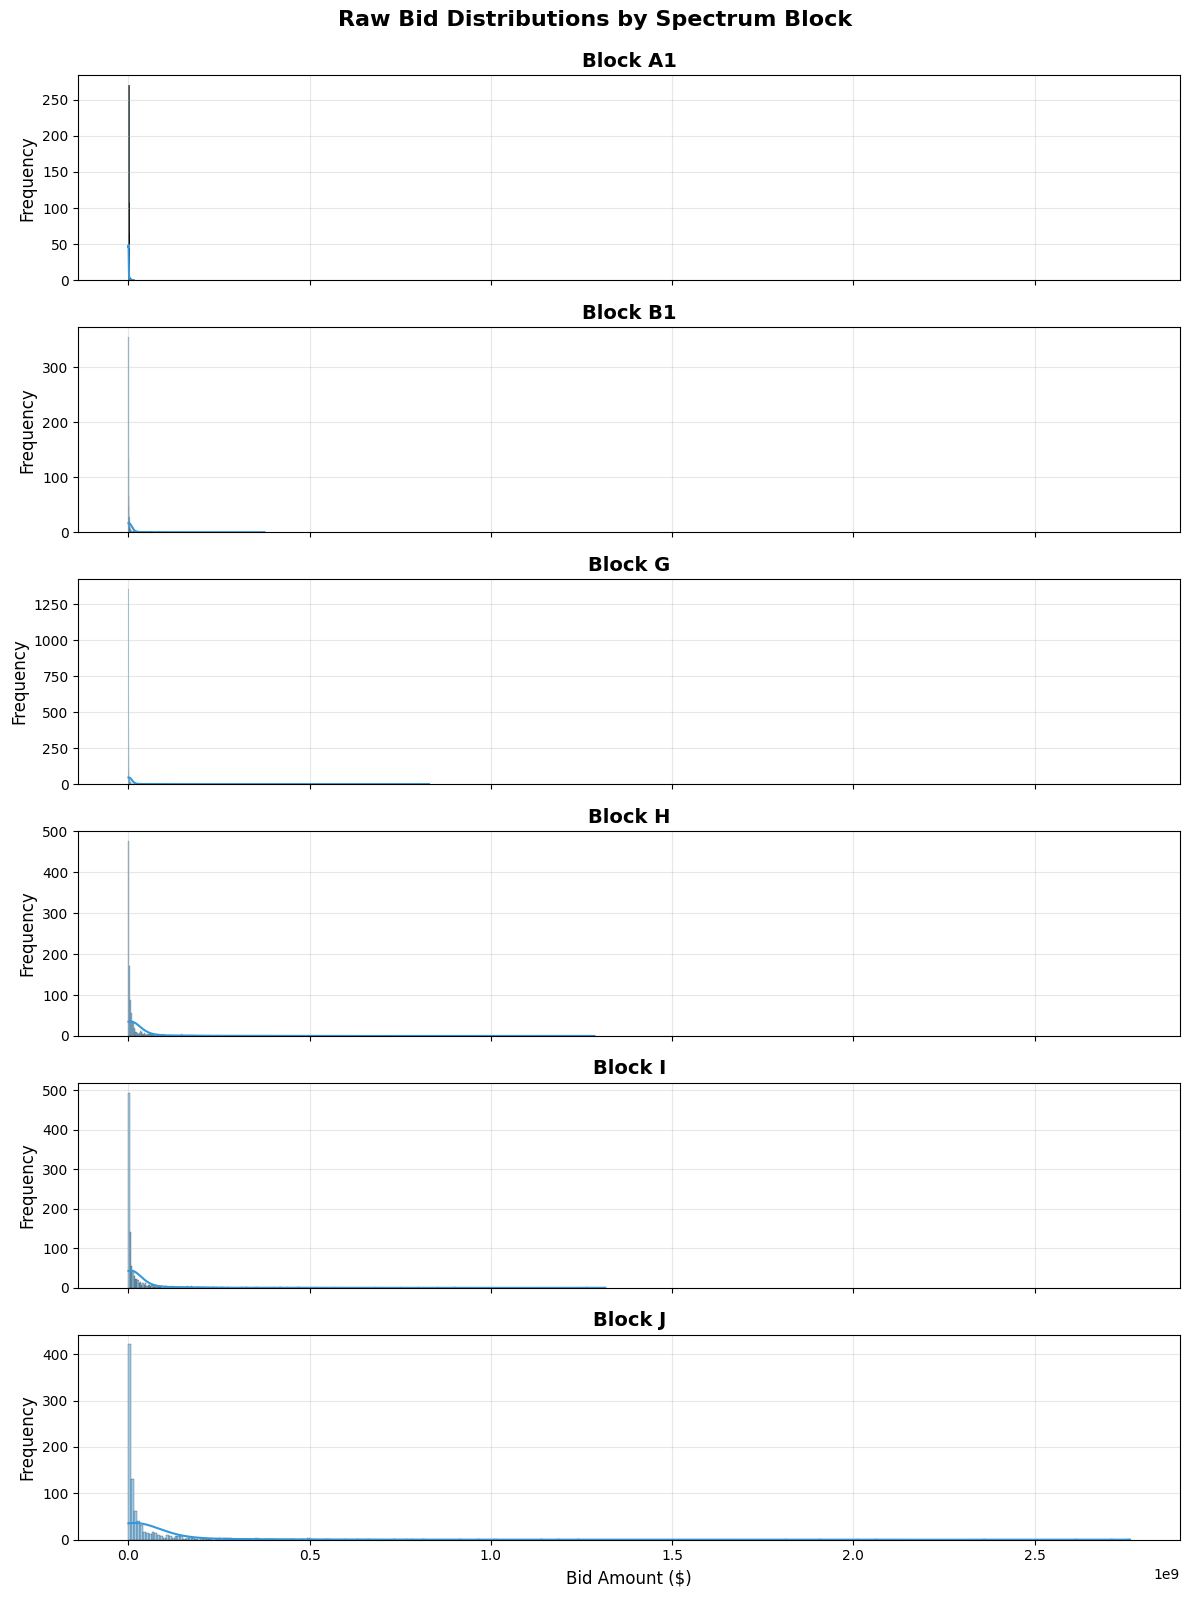

In [6]:
# Plot raw bid distributions by block
data = clean_df[["block", "bidder_name", "bid_amount"]].groupby("block")

fig, axes = plt.subplots(6, 1, figsize=(12, 16), sharex=True)

for (block, group), ax in zip(data, axes):
    sns.histplot(data=group, x="bid_amount", kde=True, ax=ax, color="#3498DB")
    ax.set_title(f"Block {block}", fontsize=14, fontweight="bold")
    ax.set_xlabel("Bid Amount ($)", fontsize=12)
    ax.set_ylabel("Frequency", fontsize=12)
    ax.grid(True, alpha=0.3)

plt.suptitle(
    "Raw Bid Distributions by Spectrum Block", fontsize=16, fontweight="bold", y=0.995
)
plt.tight_layout()
plt.show()

Apply log transformation to handle the wide range of bid values, then normalize to [1, 10] range to match simulated data.

In [7]:
# Log transform
clean_df["log_bid"] = clean_df["bid_amount"].transform(np.log)
log_data = clean_df[["block", "bidder_name", "log_bid"]].groupby("block")

# Check log-transformed ranges
print("Log-transformed bid ranges by block:")
print(log_data["log_bid"].agg(["min", "max", "mean", "std"]).round(2))

Log-transformed bid ranges by block:
         min    max   mean   std
block                           
A1      7.24  16.54  12.18  1.73
B1      7.60  19.74  13.55  2.04
G       6.91  20.54  13.32  2.08
H       9.62  20.97  15.20  2.00
I       9.95  21.00  15.27  2.09
J      10.76  21.74  16.20  2.03


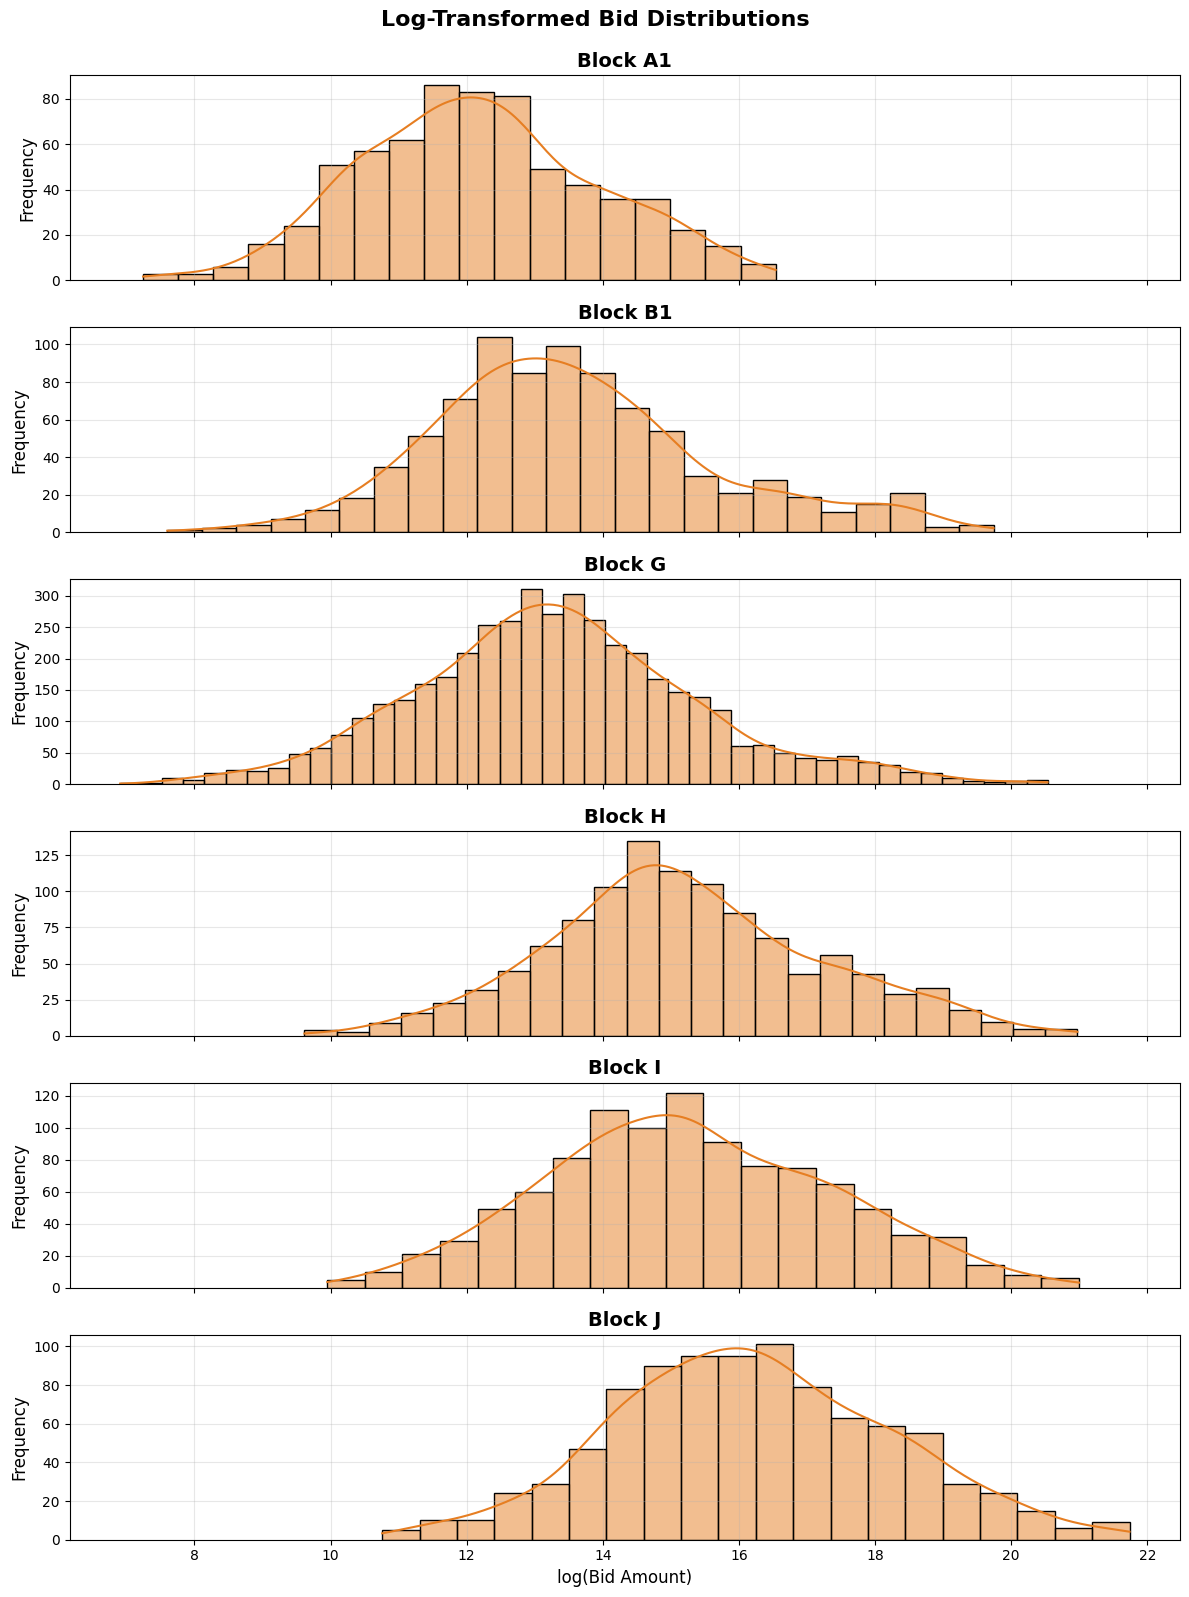

In [8]:
# Plot log-transformed distributions
fig, axes = plt.subplots(6, 1, figsize=(12, 16), sharex=True)

for (block, group), ax in zip(log_data, axes):
    sns.histplot(data=group, x="log_bid", kde=True, ax=ax, color="#E67E22")
    ax.set_title(f"Block {block}", fontsize=14, fontweight="bold")
    ax.set_xlabel("log(Bid Amount)", fontsize=12)
    ax.set_ylabel("Frequency", fontsize=12)
    ax.grid(True, alpha=0.3)

plt.suptitle(
    "Log-Transformed Bid Distributions", fontsize=16, fontweight="bold", y=0.995
)
plt.tight_layout()
plt.show()

In [9]:
# Normalize to [1, 10] range (matching simulated data bounds)
target_min, target_max = 1.0, 10.0

clean_df["scaled_log_bid"] = clean_df.groupby("block")["log_bid"].transform(
    lambda x: target_min
    + ((x - x.min()) / (x.max() - x.min())) * (target_max - target_min)
)

scaled_log_data = clean_df[["block", "bidder_name", "scaled_log_bid"]].groupby("block")

print("Normalized bid statistics by block:")
print(scaled_log_data["scaled_log_bid"].agg(["min", "max", "mean", "std"]).round(2))

Normalized bid statistics by block:
       min   max  mean   std
block                       
A1     1.0  10.0  5.77  1.67
B1     1.0  10.0  5.41  1.51
G      1.0  10.0  5.24  1.38
H      1.0  10.0  5.43  1.58
I      1.0  10.0  5.34  1.71
J      1.0  10.0  5.46  1.67


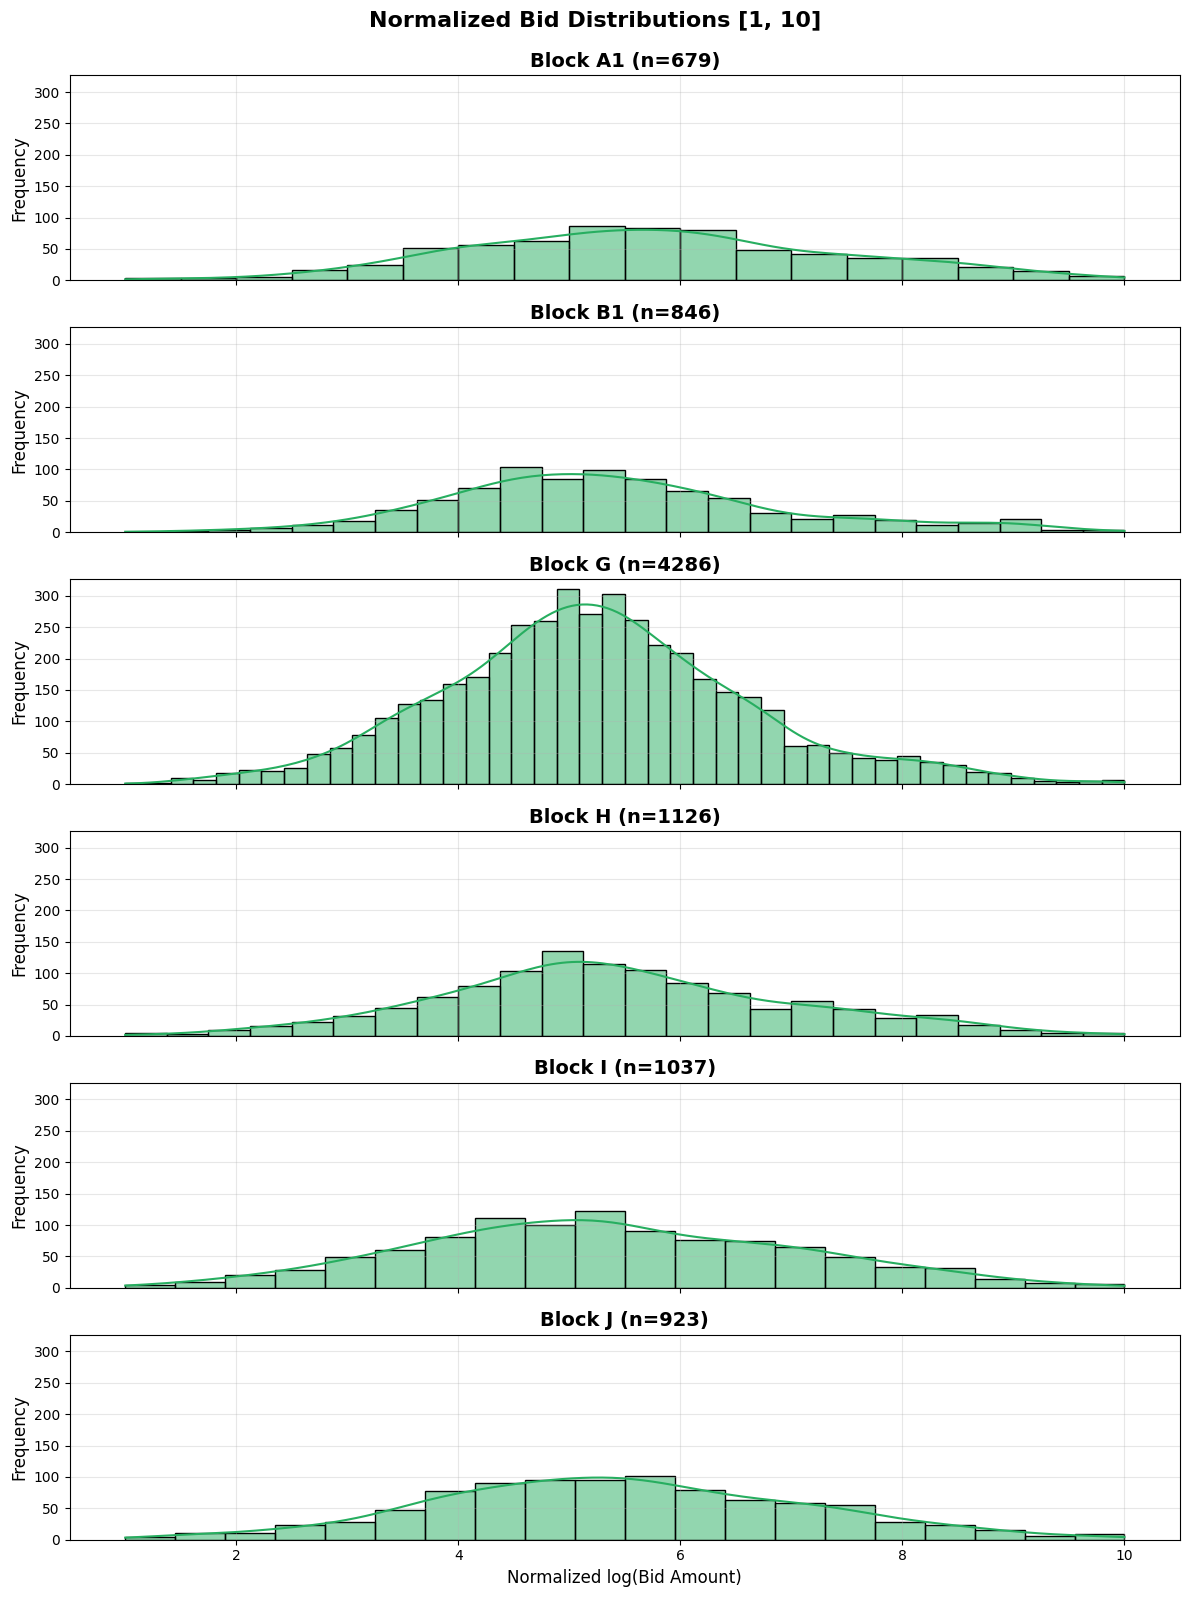

In [10]:
# Plot normalized distributions
fig, axes = plt.subplots(6, 1, figsize=(12, 16), sharex=True, sharey=True)

for (block, group), ax in zip(scaled_log_data, axes):
    sns.histplot(data=group, x="scaled_log_bid", kde=True, ax=ax, color="#27AE60")
    ax.set_title(f"Block {block} (n={len(group)})", fontsize=14, fontweight="bold")
    ax.set_xlabel("Normalized log(Bid Amount)", fontsize=12)
    ax.set_ylabel("Frequency", fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0.5, 10.5)

plt.suptitle(
    "Normalized Bid Distributions [1, 10]", fontsize=16, fontweight="bold", y=0.995
)
plt.tight_layout()
plt.show()

Overlay all spectrum block distributions to confirm from the same distribution family.

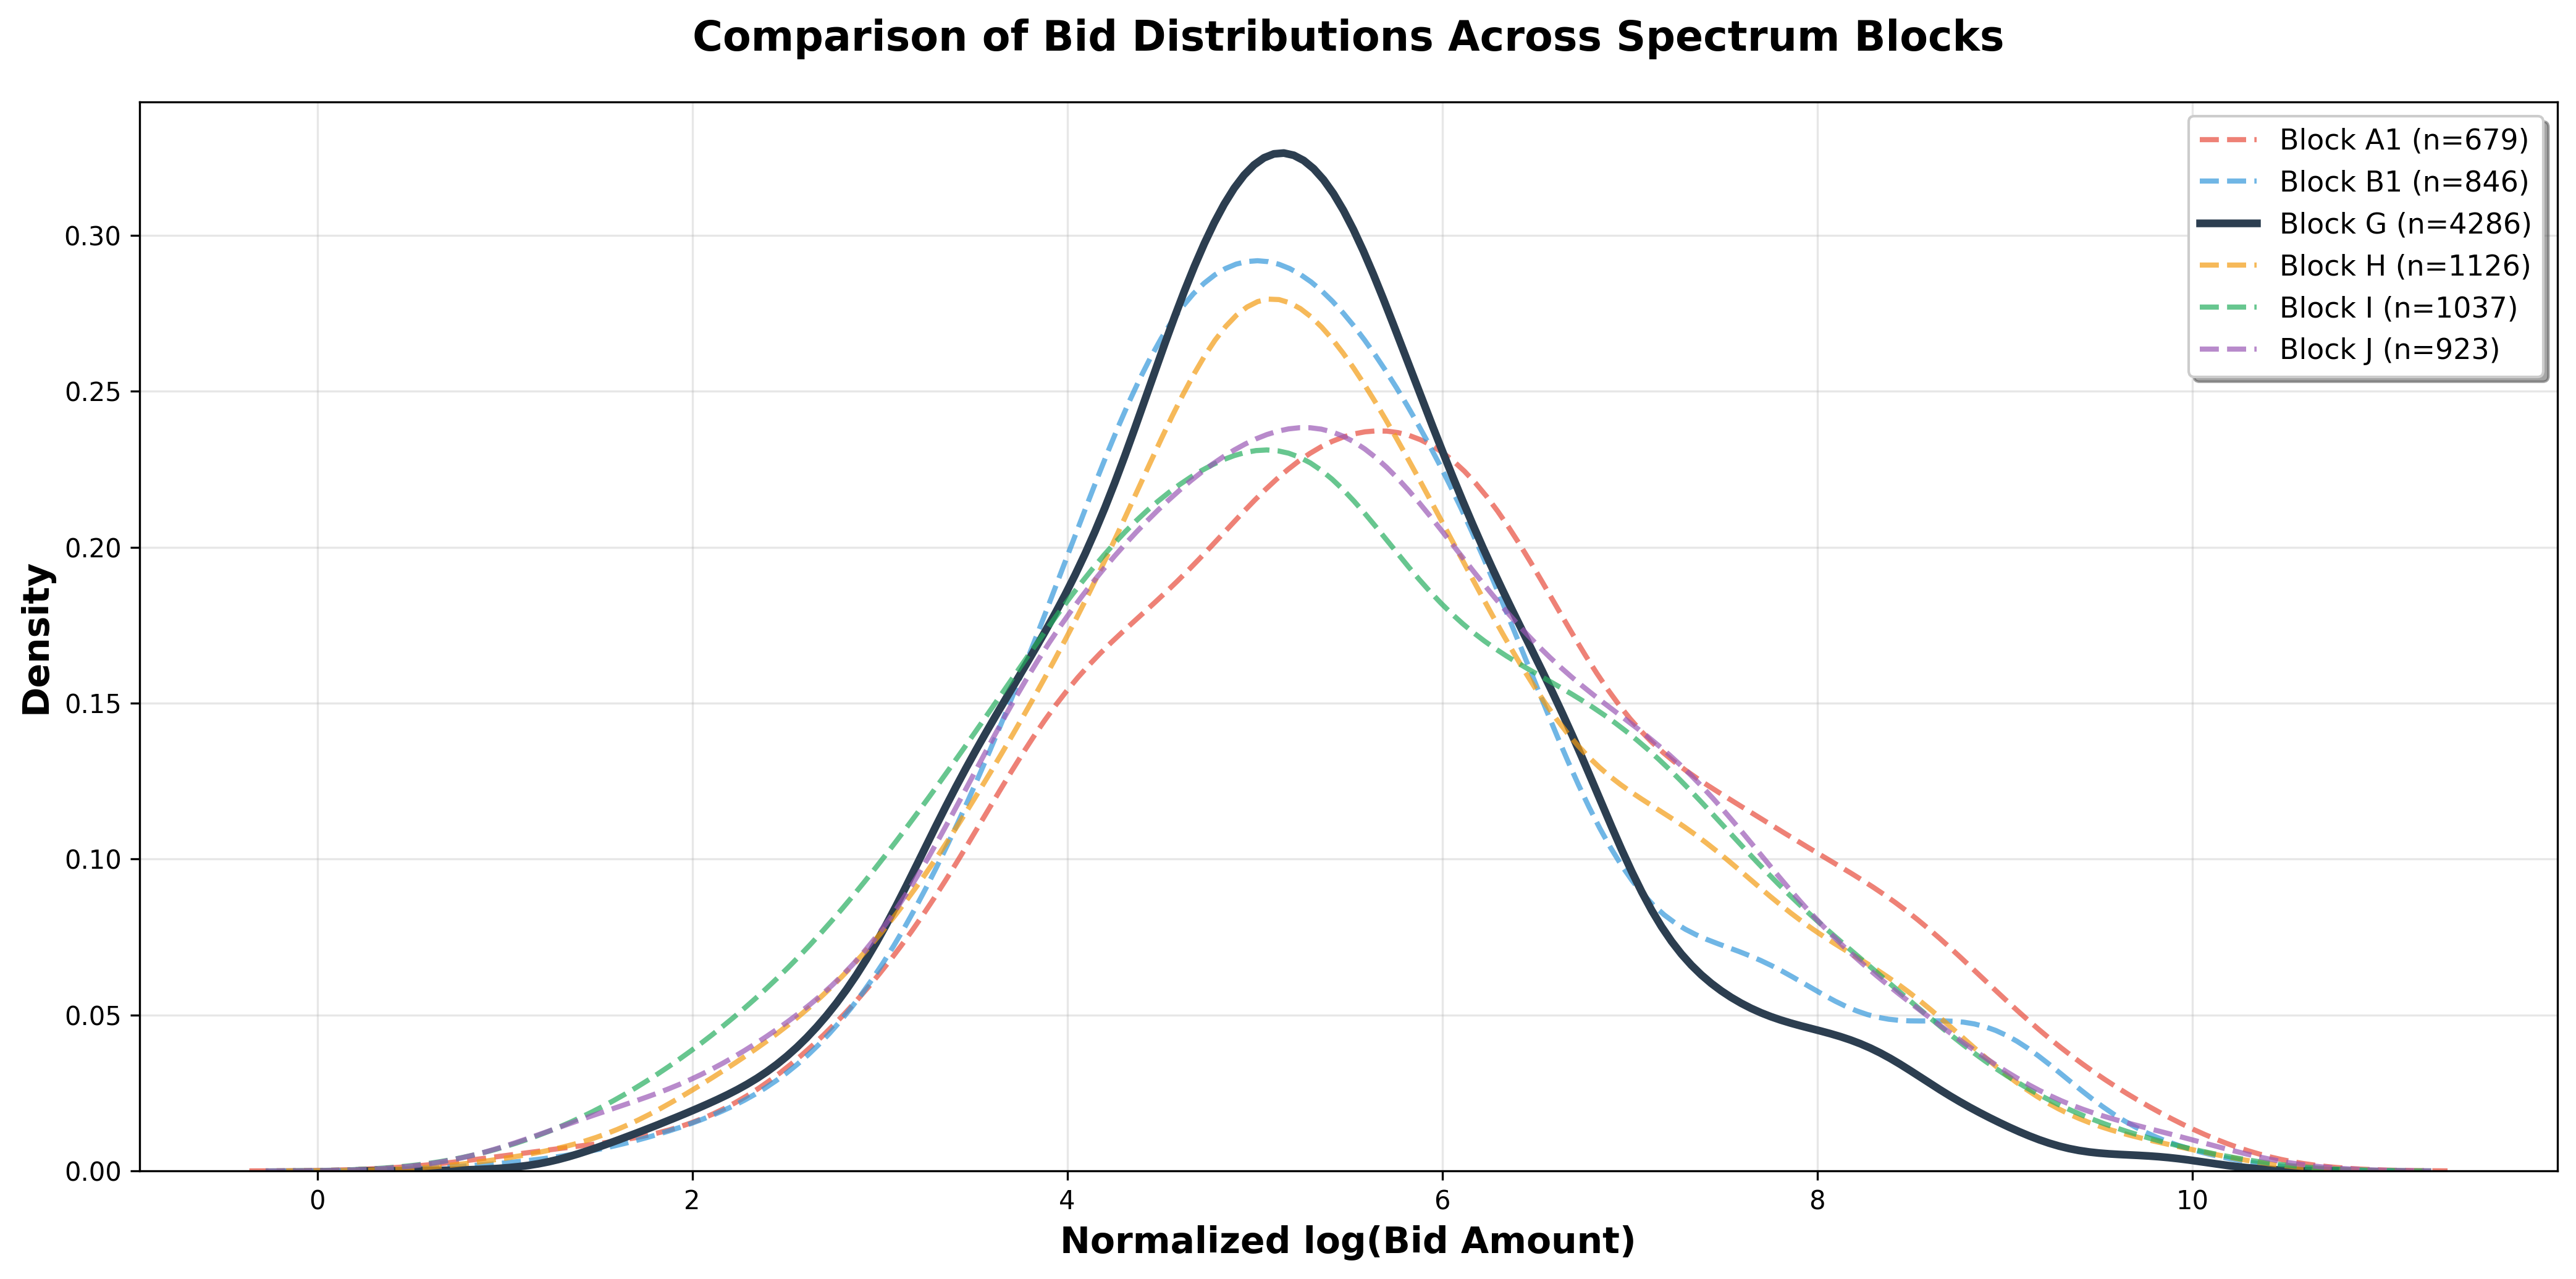

📊 Block G selected as test distribution (largest sample size)


In [11]:
# Overlay all block distributions
plt.figure(figsize=(14, 7), dpi=300)

colors = {
    "A1": "#E74C3C",
    "B1": "#3498DB",
    "G": "#2C3E50",
    "H": "#F39C12",
    "I": "#27AE60",
    "J": "#9B59B6",
}

for block, group in scaled_log_data:
    block_str = str(block)  # Convert to string for type safety
    if block == "G":
        # Emphasize Block G (test distribution)
        sns.kdeplot(
            data=group,
            x="scaled_log_bid",
            label=f"Block {block_str} (n={len(group)})",
            color=colors[block_str],
            linewidth=3,
        )
    else:
        sns.kdeplot(
            data=group,
            x="scaled_log_bid",
            label=f"Block {block_str} (n={len(group)})",
            color=colors[block_str],
            linestyle="--",
            linewidth=2,
            alpha=0.7,
        )

plt.xlabel("Normalized log(Bid Amount)", fontsize=14, fontweight="bold")
plt.ylabel("Density", fontsize=14, fontweight="bold")
plt.title(
    "Comparison of Bid Distributions Across Spectrum Blocks",
    fontsize=16,
    fontweight="bold",
    pad=20,
)
plt.legend(fontsize=11, loc="upper right", frameon=True, shadow=True)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("📊 Block G selected as test distribution (largest sample size)")

## Step 3: Generate Training and Test Datasets from Real Data

In [12]:
# 📊 Experiment Configuration
# Test data configuration
N_RUNS = 1000
N_AUCTIONS = 200
BIDS_PER_AUCTION = [10, 50, 100, 200]
TEST_SEED = 0
K_FOLDS = [2, 5, 10]


# RDE training configurations
RDE_CONFIGS = [(200, 20), (20, 200), (200, 200)]  # (N_train, n_train)
TRAIN_AUCTIONS = max(N for N, n in RDE_CONFIGS)
TRAIN_BIDS_PER_AUCTION = max(n for N, n in RDE_CONFIGS)
TRAIN_SEED = 9999

total_configs = len(BIDS_PER_AUCTION) * len(K_FOLDS)

print(
    f"📊 {len(BIDS_PER_AUCTION)} bids × {len(K_FOLDS)} K = {len(BIDS_PER_AUCTION)*len(K_FOLDS)} experiments"
)

📊 4 bids × 3 K = 12 experiments


**Data Generated:**
- ✅ Test data: 1000 runs × 200 auctions × 200 bids
  - Source: Block G (single source, largest sample)
  - Method: Bootstrap with KDE CDF estimation
  - Cached at: `workspace/real/data/real_a200_b200_r1000_s0_test.json`

- ✅ Training data: 1 run × 200 auctions × 200 bids
  - Sources: Blocks A1, B1, H, I, J (mixed sources)
  - Method: Each auction randomly selects a block, then bootstraps
  - Cached at: `workspace/real/data/real_a200_b200_s9999_train.json`

In [13]:
# Extract all blocks
block_bids = {
    block: np.asarray(group["scaled_log_bid"]) for block, group in scaled_log_data
}
print(
    f"✅ {len(block_bids)} blocks: {', '.join(f'{b}({len(v)})' for b, v in block_bids.items())}"
)

✅ 6 blocks: A1(679), B1(846), G(4286), H(1126), I(1037), J(923)


In [14]:
# Generate test data using simulate_experiment_data
test_data = simulate_experiment_data(
    dist_name="real",
    purpose="test",
    n_auctions=N_AUCTIONS,
    bids_per_auction=max(BIDS_PER_AUCTION),
    real_bids=[block_bids["G"]],  # Single source: Block G
    lower=1.0,
    upper=10.0,
    seed=TEST_SEED,
    n_runs=N_RUNS,
)

print(f"✅ Generated test data: {len(test_data)} runs × {len(test_data[0])} auctions")

📂 Loading cached data: real_a200_b200_r1000_s0_test.json
✅ Loaded 1000 runs × 200 auctions
✅ Generated test data: 1000 runs × 200 auctions


In [15]:
# Generate training data using simulate_experiment_data
train_data = simulate_experiment_data(
    dist_name="real",
    purpose="train",
    n_auctions=TRAIN_AUCTIONS,
    bids_per_auction=TRAIN_BIDS_PER_AUCTION,
    real_bids=[block_bids[b] for b in ["A1", "B1", "H", "I", "J"]],  # Multiple sources
    lower=1.0,
    upper=10.0,
    seed=TRAIN_SEED,
)

print(
    f"✅ Generated training data: {len(train_data)} run × {len(train_data[0])} auctions"
)

📂 Loading cached data: real_a200_b200_r1_s9999_train.json
✅ Loaded 1 runs × 200 auctions
✅ Generated training data: 1 run × 200 auctions


## Step 4: Train RDE Models on Real Auction Patterns

Extract training bids and train RDE models with different configurations.

In [16]:
# Extract training bids for RDE
train_bids = np.array([auction.bids for auction in train_data[0]])
print(f"📦 Training bids shape: {train_bids.shape}")

# Train RDE models
rde_models = {}
for N_train, n_train in RDE_CONFIGS:
    print(f"\n🔧 Training RDE model: N={N_train}, n={n_train}")
    model = train_rde_model(
        dist_name="real",
        train_bids=train_bids,
        train_seed=TRAIN_SEED,
        N_train=N_train,
        n_train=n_train,
    )
    rde_models[(N_train, n_train)] = model
    print("   ✅ Model trained and cached")

print(f"\n✅ All {len(rde_models)} RDE models ready!")

📦 Training bids shape: (200, 200)

🔧 Training RDE model: N=200, n=20
📂 Loading cached RDE model: a200_b200_s9999/real_N200_l1_n20_u10.pkl
✅ Loaded RDE model
   (train: 200×200, used: 200×20)
   ✅ Model trained and cached

🔧 Training RDE model: N=20, n=200
📂 Loading cached RDE model: a200_b200_s9999/real_N20_l1_n200_u10.pkl
✅ Loaded RDE model
   (train: 200×200, used: 20×200)
   ✅ Model trained and cached

🔧 Training RDE model: N=200, n=200
📂 Loading cached RDE model: a200_b200_s9999/real_N200_l1_n200_u10.pkl
✅ Loaded RDE model
   (train: 200×200, used: 200×200)
   ✅ Model trained and cached

✅ All 3 RDE models ready!


## Step 5: Compare Pricing Methods on Real Data

Run experiments for all methods across different configurations.

In [17]:
# Build list of all methods to test
methods_to_test = []

# Base methods
for method in ["ecdf", "kde", "myerson"]:
    methods_to_test.append({"name": method, "method": method, "kwargs": {}})

# RDE methods with different training configs
for N_train, n_train in RDE_CONFIGS:
    methods_to_test.append(
        {
            "name": f"RDE ({N_train}×{n_train})",
            "method": "rde",
            "slug": f"rde_{N_train}x{n_train}",
            "kwargs": {"rde_model": None},  # Will be set below
        }
    )

# Calculate totals
total_configs = sum(len([k for k in K_FOLDS if k <= bids]) for bids in BIDS_PER_AUCTION)
total_experiments = total_configs * len(methods_to_test)

print(
    f"Total: {total_experiments} experiments ({total_configs} setups × {len(methods_to_test)} methods)"
)
print()

Total: 72 experiments (12 setups × 6 methods)



In [ ]:
# Run experiments
CHECKPOINT_RUNS = 100  # Checkpoint every N runs within each experiment
N_JOBS_EXPERIMENTS = -1  # Set to 4 or -1 for parallel execution
all_results = []
config_count = 0
start_time = time.time()

# Loop through 2D grid: (bids, K)
for bids_per_auction in BIDS_PER_AUCTION:
    for k in [k for k in K_FOLDS if k <= bids_per_auction]:
        config_count += 1
        print(
            f"\nSetup {config_count}/{total_configs}: {bids_per_auction} bids × K={k}"
        )

        # Test all methods on this configuration
        for method_config in methods_to_test:
            method_name = method_config["name"]
            method_slug = method_config.get("slug", method_config["method"])

            # Set RDE model if needed
            kwargs = method_config["kwargs"].copy()
            if method_config["method"] == "rde":
                N_train, n_train = [
                    (N, n) for N, n in RDE_CONFIGS if f"RDE ({N}×{n})" == method_name
                ][0]
                kwargs["rde_model"] = rde_models[(N_train, n_train)]

            # Run experiment (handles caching/checkpointing internally)
            print(f"  🔧 {method_name}...", end=" ", flush=True)
            result = run_experiments(
                experiment_data=test_data,
                method=method_config["method"],
                n_auctions=N_AUCTIONS,
                bids_per_auction=bids_per_auction,
                k=k,
                n_jobs=N_JOBS_EXPERIMENTS,
                dist_name="real",
                method_slug=method_slug,
                checkpoint_every=CHECKPOINT_RUNS,
                **kwargs,
            )

            # Add metadata
            result["method"] = method_name
            result["bids_per_auction"] = bids_per_auction
            result["k"] = k
            all_results.append(result)

            print(f"mean={result['mean_regret']:.4f}")

# Summary
elapsed_time = time.time() - start_time
total_completed = len(all_results)

print(f"\n{'=' * 60}")
print(f"✅ Complete! {total_completed} experiments")
print(f"   Time: {elapsed_time:.1f}s ({elapsed_time/60:.1f} min)")
print(f"{'=' * 60}")


Setup 1/12: 10 bids × K=2
  🔧 ecdf... ✅ Experiment already complete (loaded from cache)
mean=0.5222
  🔧 kde... ✅ Experiment already complete (loaded from cache)
mean=0.2290
  🔧 myerson... ✅ Experiment already complete (loaded from cache)
mean=0.4336
  🔧 RDE (200×20)... ✅ Experiment already complete (loaded from cache)
mean=-0.0059
  🔧 RDE (20×200)... ✅ Experiment already complete (loaded from cache)
mean=0.0164
  🔧 RDE (200×200)... ✅ Experiment already complete (loaded from cache)
mean=-0.0177

Setup 2/12: 10 bids × K=5
  🔧 ecdf... ✅ Experiment already complete (loaded from cache)
mean=0.3977
  🔧 kde... ✅ Experiment already complete (loaded from cache)
mean=0.1536
  🔧 myerson... ✅ Experiment already complete (loaded from cache)
mean=0.3862
  🔧 RDE (200×20)... ✅ Experiment already complete (loaded from cache)
mean=-0.0075
  🔧 RDE (20×200)... 
Running experiments: rde
Config: 1000 runs × 200 auctions (starting from run 0)
Mode: Parallel (10 cores)

📊 Progress: 100/1000 runs complete
📊 P